<h2>Classification Project 2</h2>

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn.decomposition import PCA
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from scipy.stats import multivariate_normal as mvn
import math
import warnings
warnings.filterwarnings('ignore')


In [0]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test)=mnist.load_data()

In [0]:
nsamples, nx, ny = x_train.shape
Xtrain = x_train.reshape((nsamples,nx*ny))#It is converting our 28*28 pixel(2D Array) into 784(1d) array for X_train
nsamples1, nx1, ny1 = x_test.shape
Xtest= x_test.reshape((nsamples1,nx1*ny1))#It is converting our 28*28 pixel(2D Array) into 784(1d) array for X_test
ren=Xtrain
Ytrain=pd.Series(y_train)
dfre=pd.DataFrame(ren)

<h2> Question 1 </h2>

In [0]:
#calculating mean and variance for every digit
label = sorted(Ytrain.unique())
m = Ytrain.unique().shape[0]
n = dfre.shape[1]
mu = np.zeros((m,n))# array of zeros
si = np.zeros((m,n))
for i in label:
    mu[i] = dfre[Ytrain==i].mean()#calculates mean of each and every digit
    si[i] = dfre[Ytrain==i].var()#calculates variance of each and every digit

In [0]:
#confusion matrix
def confusionmatrix(y_test, y_pred):
    plt.figure(figsize=(10,10))
    m = confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(m, annot=True, fmt="d")
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('confusion matrix')
    acc = accuracy_score(y_test, y_pred)
    print(f"Classification accuracy: {acc}")

In [0]:
def predict(X):
    N, D = dfre.shape#shaoe of Xtrain
    K = m #number of labels
    P = np.zeros((N, K))
    for c in label:
        mean=mu[c]
        var=si[c]+1000 # Tested different smoothing values and i got maximum accuracy value for 1000
        num=np.exp(-(X-mean)**2/(2*var))#numerator part of the gaussian distribution model
        den=np.sqrt(2*np.pi*var)#denominator part of the gaussian distribution model
        P[:,c] = np.sum(np.log(num/den))
        #mvn.logpdf(X, mean=mean, cov=var)
    #print(np.argmax(P))
    return np.argmax(P)

In [0]:
#For classification accuracy
y_pred = np.zeros((Xtest.shape[0]))
for n in range(Xtest.shape[0]):
    y_pred[n] = predict(Xtest[n])
print("Classification Accuracy is {0}".format(accuracy_score(y_test, y_pred)))

Classification Accuracy is 0.8149


Classification accuracy: 0.8149


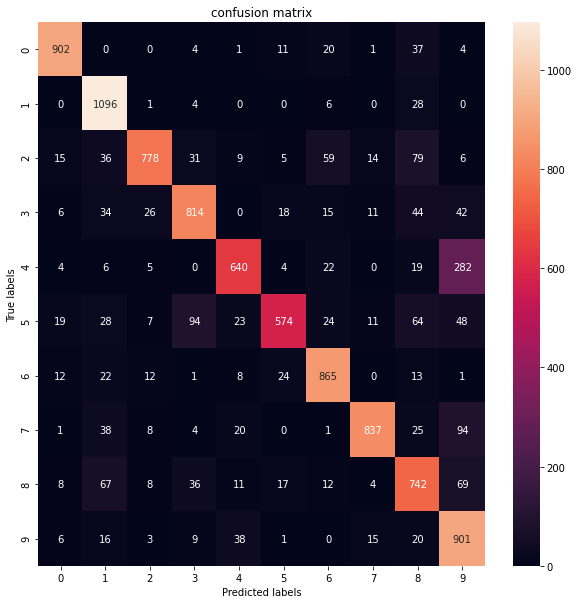

In [0]:
#Confusion Matrix
confusionmatrix(y_test, y_pred)

In [0]:
def TestErrorDigits(pred,y_test):#This Function Will return a data frame containing testing error for each and every digit
    rray=[0,0,0,0,0,0,0,0,0,0]
    for i in range(len(y_test)):
        if(pred[i]!=y_test[i]):#checking whether our predicted output and given label are same or not
            rray[y_test[i]]=rray[y_test[i]]+1
    err=[]
    accu=[]
    (unique, counts) = np.unique(y_test, return_counts=True)#This will give us the output how many times digits are present in the ytest 
    #print(len(rray))
    for i in range(len(rray)):
        err.append((rray[i]/counts[i])*100)
        accu.append(100-((rray[i]/counts[i])*100))
    d={'Digits':[0,1,2,3,4,5,6,7,8,9],'Testing Error%':err,'Accuracy%':accu}
    df=pd.DataFrame(d)
    return df 

In [0]:
table=TestErrorDigits(y_pred,y_test)
print("Table for testing errors of each and every digit in the mnist dataset")
table

Table for testing errors of each and every digit in the mnist dataset


,Digits,Testing Error%,Accuracy%
0,0,7.959184,92.040816
1,1,3.436123,96.563877
2,2,24.612403,75.387597
3,3,19.405941,80.594059
4,4,34.826884,65.173116
5,5,35.650224,64.349776
6,6,9.707724,90.292276
7,7,18.579767,81.420233
8,8,23.819302,76.180698
9,9,10.703667,89.296333


Text(0.5, 0.98, 'Naive Bayes Conditional Probability images')

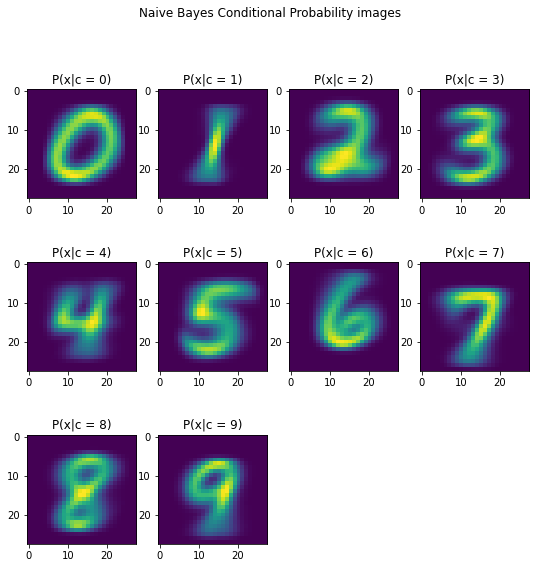

In [0]:
plt.figure(figsize=(9,9))
for i in label:
    plt.subplot(3,4, i+1)
    plt.title("P(x|c = {})".format(i))
    img = np.array( mu[i] ).reshape(28,28)
    plt.imshow(img)
plt.suptitle('Naive Bayes Conditional Probability images')    

The above images states that the mean of each class very closely captures what that digit typically looks like in this classifier.so, we can say that the model has learned from the mean for each class. 

Comments on our results:
1) We can tell from the confusion matrix that the digit 4 has been miss classified as 9 and vice versa for about 282 images.
2) We can tell from the accuracy table that the digit 5 and 4  are  miss classified as other digits more times. 
3) We achived about only 81.49 percent overall accuracy. This is because naive bayes makes pre-mature assumptions.

<h2> Question 2 </h2>

Derivation of update equation for regularized logistic regression 

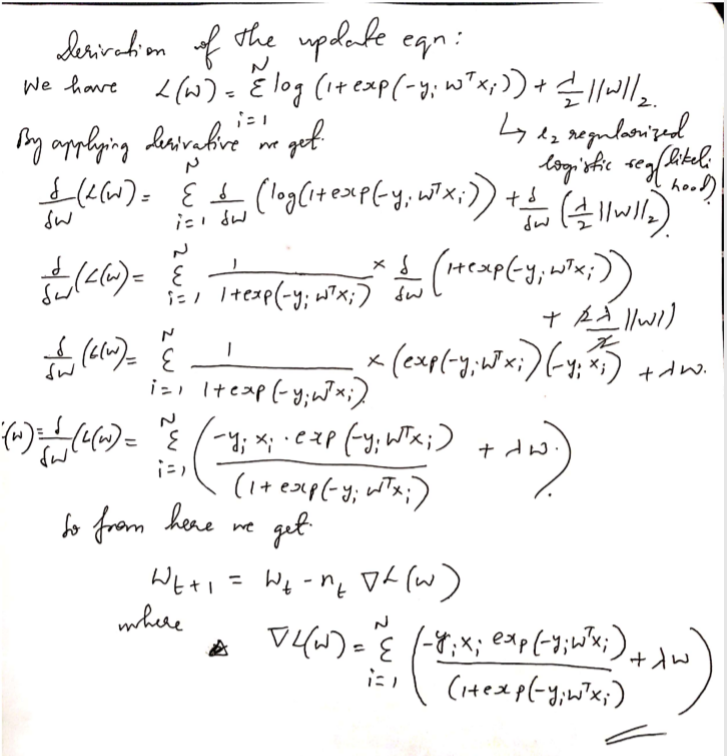

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
"""
Normalizing the input data because  when you apply the sigmoid / logit function to your hypothesis, 
the output probabilities are almost all approximately 0s or all 1s and with your cost function, log(1 - 1) or log(0) 
will produce -Inf. The accumulation of all of these individual terms in your cost function will eventually lead to NaN.
"""
scalar = StandardScaler()
scalar.fit(Xtrain)
Xtrain= scalar.transform(Xtrain)
scalar.fit(Xtest)
Xtest = scalar.transform(Xtest)
#bias = np.ones((Xtrain.shape[0], 1))
#Xtrain = np.hstack((bias, Xtrain))
#bias = np.ones((Xtest.shape[0], 1))
#Xtest = np.hstack((bias, Xtest))
acc=[]
lamda=[0.001,0.01,0.1,1,10,100]
for l in lamda:
    # We are performing logistic regression using different lamba valuew and will select the best lamba value by predicting the accuracy
    # we are performing te logistic regression gradient iteration 
    model = LogisticRegression(C=l, random_state=0,max_iter=1000,penalty='l2')#logistic regression model with l2 regularization and maximum iterations of 1000
    model.fit(Xtrain, y_train)
    y_pred= model.predict(Xtest)
    acc.append(accuracy_score(y_test,y_pred))#This list contains Accuracy of all the classifiers with different lamda values

Classification  accuray  is 0.9263 where lamba is 0.1
Classification accuracy: 0.9263


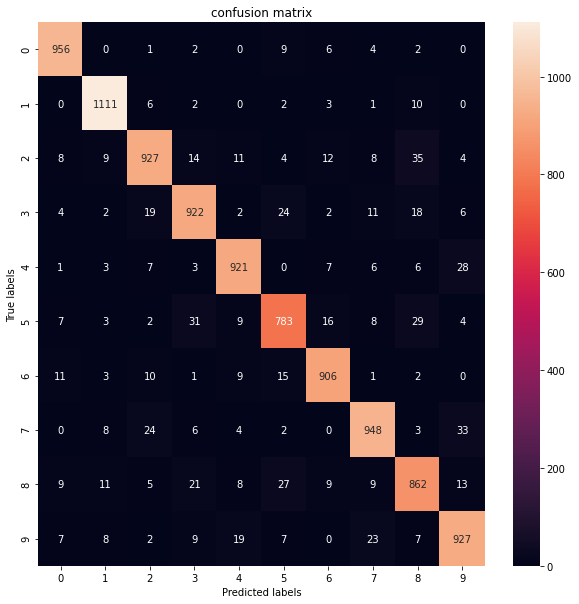

In [0]:
#Classification accuracy and the confusion matrix
k=acc.index(max(acc))# This will get the index of maximum accuracy value from the list acc
best=lamda[k]# Lamda value with the best accuracy
model = LogisticRegression(C=best, random_state=0,max_iter=1000,penalty='l2')
model.fit(Xtrain, y_train)
y_pred= model.predict(Xtest)
print("Classification  accuray  is {0} where lamba is {1}".format((accuracy_score(y_test,y_pred)),best))
weights=list(model.coef_)# Weights of the 10 classifiers
confusionmatrix(y_test, y_pred)#It prints the confusion matrix

In [0]:
#Testing error rate for every digit
table=TestErrorDigits(y_pred,y_test)
print("Table for testing errors of each and every digit in the mnist dataset")
table

Table for testing errors of each and every digit in the mnist dataset


,Digits,Testing Error,Accuracy
0,0,2.448980,97.551020
1,1,2.114537,97.885463
2,2,10.174419,89.825581
3,3,8.712871,91.287129
4,4,6.211813,93.788187
5,5,12.219731,87.780269
6,6,5.427975,94.572025
7,7,7.782101,92.217899
8,8,11.498973,88.501027
9,9,8.126858,91.873142


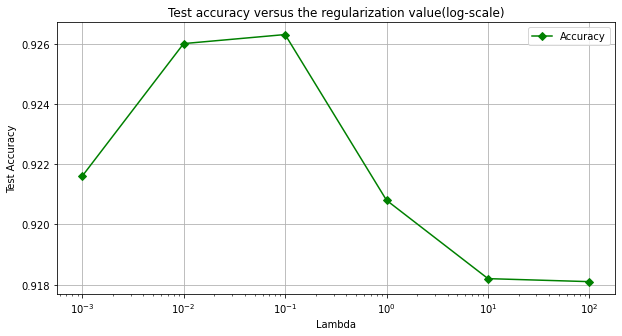

In [0]:
#Testaccuracy vs lamda plot
plt.subplots(figsize=(10, 5))
plt.semilogx(lamda, acc,'-gD' , label="Accuracy")
#matplot.xticks(L,L)
plt.grid(True)
plt.xlabel("Lambda")
plt.ylabel("Test Accuracy")
plt.legend()
plt.title('Test accuracy versus the regularization value(log-scale)')
plt.show()

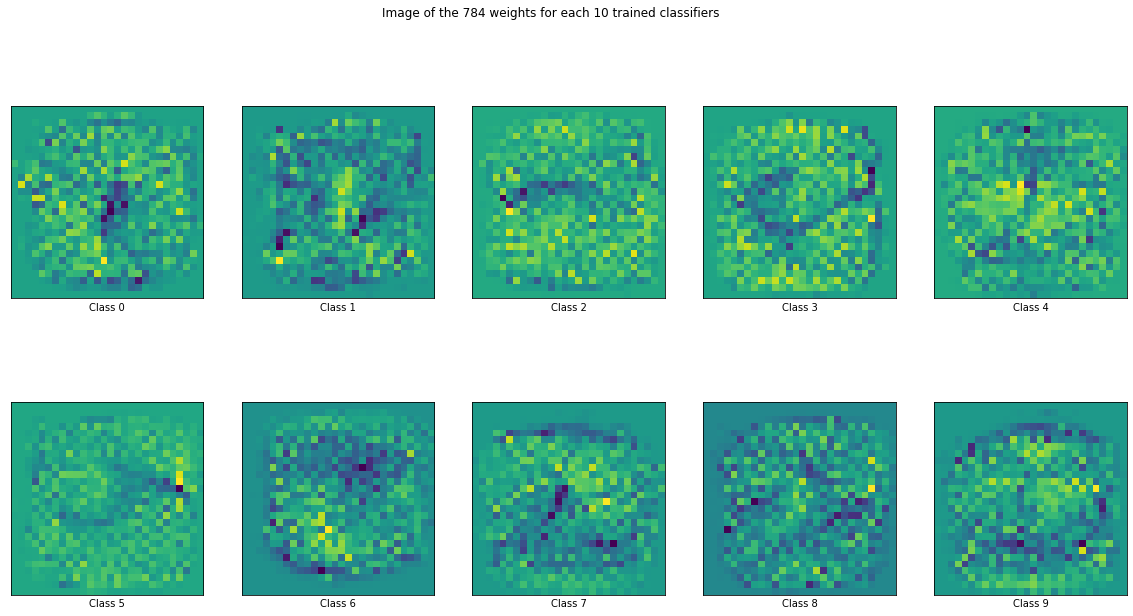

In [0]:
plt.subplots(2,5, figsize=(20,10))
for i in range(0,10):
    l1 = plt.subplot(2, 5, i + 1)
    l1.imshow(weights[i].reshape(28, 28), interpolation='nearest')
    l1.set_xticks(())
    l1.set_yticks(())
    l1.set_xlabel('Class %i' % i)
plt.suptitle('Image of the 784 weights for each 10 trained classifiers')
plt.show()

Logisitic regression is better than naive bayes. Naive bayes classifier is faster than logistic regression but logistic regression is more reliable compared to naive bayes. This is because in logistic regression classification it doesn't take any pre-mature assumptions. The plotted weights of the classes shows the pattern for each of the digit although it is not pretty clear due the noises. If we look close on the weights plot, we can see the corressponding digit visible on the plot.



The accuracy for the naive bayes is 0.8149 and for the logistic regression the accuracy is 0.9263. By comparing both the accuracies, logistic regression classifier is the better compared to naive bayes classiffier. This clears the fact that how logistic regression uses the weights that are patterns for each digits and predicts the label for new images.

Further in the confusion matrix plot we say that 2s are predcited to be 8s. Now if you see the weight plots are 2 and 8, you can see that there is lot of similarity between the those. And that is the reason for the misclassification and thats how logistic regression works.

